<a href="https://colab.research.google.com/github/jhho580828/github-pages/blob/main/Adding_Custom_Vocabulary_and_Continuing_Training_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding Custom Vocabulary and Continuing Training

*by Nick Ryan*

# S1. Introduction

Many NLP applications are about classifying text in very specific and unique domains. Whether you're building a sentiment classifier for an auto parts company or a chatbot for your financial services customers,  sometimes a model like BERT doesn't quite cut it because certain unique and unusual names, phrases, and terms are such a key part of your data. 

In this tutorial we will discuss how to customize a language model like BERT for your own text domain and show you how to:

- Add new words to the model vocabulary
- Create custom embeddings for those new words
- Continue training the model with your own dataset
- Run a quick test to see the progress of your continued training


## Notebook Access


-------------------------------------

[![Notebook Access](https://drive.google.com/uc?export=view&id=1yPJapK5X9kXLDhtuDJm3Hw4-ZlxMwcsa)](https://www.chrismccormick.ai/membership)

<sup>\*</sup>Notify me [here](team@chrismccormick.ai)

<sup>\*\*</sup>Join my site [here](https://www.chrismccormick.ai/membership) 

---------------------------------------



## 1.1 Background and Problem Statement


**Why Not Just Fine-Tune?**

The most common method for building a text model on top of BERT has been to use the pretrained BERT model as a basis for fine-tuning a classifier on your specific application. However, sometimes your application uses text and terminology from a specific domain that is not reflected in the training corpus used by BERT, SciBERt, BioBERT or other variants, resulting in vocabulary and weights poorly suited to your application. 

For example, say you work in the automotive industry and want to build an NLP application revolving around automotive brands and the mention of your new company named "carz4friendz." You could fine-tune your model on top of a pretrained BERT model, but because BERT was trained on a limited amount of technical automotive data it will have a poor "understanding" of automative brands, parts, technical terminiology, and will not have an understanding or efficient tokenization of your new company name, which is a critical part of the application. 

**Customizing Vocabulary and "Intermediate" Training**

In this case there are two things you can do to help give your NLP application a boost:

1.  Add new terms to the model vocabulary that are particularly important for your application. In our example, we would add the name of our automative company "carz4friendz" to BERT's vocabulary.
2.  Continue pretraining the model or fine-tuning the model on an "intermediate" task focused on text data that is relevant to your final application. In our example, we would continue pretraining BERT on news articles, industry reports, and text from the automotive industry to help improve the model's performance when it comes to automotive text.

![Intermediate Pre-Training](https://drive.google.com/uc?export=view&id=1TLvg8OXUDugyZo2_cVsWElzbuKuUzi9O)

**Applying this Approach to COVID-19**

In this tutorial, we'll apply these two solutions to an application everyone is familiar with: COVID-19. SciBERT was trained largely on a biomedical corpus so is a good candidate base for coronavirus-related NLP applications if we want to search, index, cluster, etc. coronavirus research publications. However, SciBERT was trained in early 2019, so the model was never trained on coronavirus research, nor does it even have a vocabulary entry for some of the key terms we would need for our application like "coronavirus," "COVID-19", "COVID", etc.

We will first update the SciBERT vocabulary and show you how to add relevant vocabulary to your tokenizer and model. Then we will show you how to continue training your model with a custom dataset. Specifically, we will show you how to continue the masked language modeling task used for pretraining, a task that we have not previously explored in our tutorials and one that is very simple to execute (all you need is unlabeled data!).



# S2. Import SciBERT Community Model


First we'll use SciBERT, a popular BERT variant (it has over 28,000 downloads in the past month on huggingface!). This is well suited to our task because our target domain is biomedical text.

* SciBERT was trained on scientific literature--1.14M papers.
  * Roughly 1/5th of the papers are from "the computer science domain", and the remaining 4/5ths from "the broad biomedical domain".
* SciBERT was created by the Allen Institute of AI (a highly respected group in NLP, if you're unfamiliar).
* Their paper was first submitted to arXiv in March, 2019 [here](https://arxiv.org/abs/1903.10676). They uploaded their implementation to GitHub [here](https://github.com/allenai/scibert) around the same time.



SciBERT is available from the [huggingface community models](https://huggingface.co/models). If you're interested in a BERT variant from the community models in the transformers library, importing can be incredibly simple. Most community models include instructions on the download page for importing and usage. 

To import SciBERT all we need to do is provide the appropriate path to the SciBERT model we're interested in. After that, the model and tokenizer interface and methods follow the regular huggingface interface and methods.



In [ ]:
!pip install transformers

We'll import BertForMaskedLM, the masked language modeling (MLM) variant for BERT. Simply, this is the BERT model with a masked language modeling head on top allowing us to continue the training procedure used to generate BERT and SciBERT. 

This does not include the next sentence prediction (NSP) task, which can be found under the BertForPreTraining class that includes both a NSP head and a MLM head. You are welcome to use this class or any of the other pretraining tasks used by BERT-like models, but based on the findings of papers like ROBERTA and T5, it doesn't appear that the NSP task in particular contributes much to the final model performance, so we forego it here for simplicity's sake.

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, BertForPreTraining, BertConfig
import torch
import matplotlib.pyplot as plt

scibert_tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", do_lower_case=True)
scibert_maskedlm_model = BertForMaskedLM.from_pretrained("allenai/scibert_scivocab_uncased")


# S3. Adding to the Vocabulary

## 3.1 Add a Token

Let's say that, for BERT or any of its variants, we'd like to add new vocabulary into the model. In this example, we're interested in organizing, searching, or indexing some scientific literature related to COVID-19. We want to continue training SciBERT on new batches of COVID-19 literature so that we can organize new and old research related to COVID-19.

Since SciBERT was trained before the outbreak of COVID-19, this word likely isn't in the vocabulary. In fact, we can confirm it is not:

假設對於 BERT 或其任何變體，我們想向模型中添加新詞彙。 在此示例中，我們有興趣組織、搜索或索引一些與 COVID-19 相關的科學文獻。 我們希望繼續使用新批次的 COVID-19 文獻對 SciBERT 進行訓練，以便我們可以組織與 COVID-19 相關的新舊研究。

由於 SciBERT 在 COVID-19 爆發之前接受過訓練，因此這個詞可能不在詞彙表中。 事實上，我們可以確認它不是：

In [ ]:
'covid' in scibert_tokenizer.vocab

False

While any word can be constructed out of constituent subwords, for example...

雖然任何單詞都可以由子詞組合而構成，例如......

In [ ]:
scibert_tokenizer.tokenize("covid")

['cov', '##id']

...words like "covid" and "coronavirus" will be quite important for our research, so it is perhaps worth going out of our way to teach the model new vocabulary in hopes that it improves our results downstream.


...像“covid”和“coronavirus”這樣的詞對我們的研究來說非常重要，所以我們或許值得不遺餘力地教模型新詞彙，希望它能改善我們下游的結果。

In [ ]:
test_sentence = "COVID-19, COVID, coronavirus."
scibert_tokenizer.tokenize(test_sentence)

['cov', '##id', '-', '19', ',', 'cov', '##id', ',', 'corona', '##virus', '.']

None of these key terms are in the SciBERT vocabulary. Fortunately huggingface provides an interface to add to the tokenizer's vocabulary. We will just add a single token, "covid", to demonstrate the addition of new terms to the model, but you are able to add as many terms as you like.

In [ ]:
print (len(scibert_tokenizer)) 

31090


In [ ]:
scibert_tokenizer.add_tokens(["covid"])

1

In [ ]:
print (len(scibert_tokenizer)) 

31091


In [ ]:
test_sentence = "COVID-19, COVID, coronavirus."
scibert_tokenizer.tokenize(test_sentence)

['covid', '-', '19', ',', 'covid', ',', 'corona', '##virus', '.']

Cool! "covid" is now part of the tokenizer vocabulary.

Now that the tokenizer is updated, we need to update the input embeddings of our model. We added one term to the tokenizer vocabulary so we need to add one new vector to the input embeddings:

In [ ]:
# Add a new randomly initialized vector to the end of the embeddings matrix
scibert_maskedlm_model.resize_token_embeddings(len(scibert_tokenizer)) 

Embedding(31091, 768)

In [ ]:
# New radom embedding vector
print (scibert_maskedlm_model.get_input_embeddings().weight[-1].shape)

torch.Size([768])


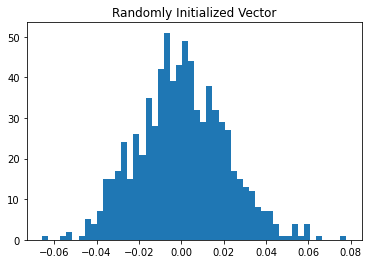

In [ ]:
random_vector = scibert_maskedlm_model.get_input_embeddings().weight[-1].detach().numpy()

plt.title("Randomly Initialized Vector")
plt.hist(random_vector, bins=50)
plt.show()

## 3.2 Create A Custom Embedding

Great! We have a new embedding vector.

There's a slight problem: this new "covid" vector is completely random while the rest of our input embeddings have been thoroughly trained. Our goal is to continue pretraining the model to update all weights in general, but also to achieve a good embedding for our new vocabulary term.

One possible workaround is to change the random embedding to something else. Instead of initializing as a random vector, we can perhaps speed up the process by initializing "covid" with an embedding slightly closer to its meaning. In this example, the embedding for "virus" is probably a good place to start, but it's possible to combine the embeddings of multiple words into an embedding we think might best approximate the meaning of our new term. We'll combine the embedding for "virus" with the embedding for "respiratory" by taking the mean, but of course you can combine any number of terms in any way you think might best approximate your new vocabulary term's meaning.

Note that this idea is experimental and application-dependent, but it's probably more efficient than training on a random initialization.

In [ ]:
# Get the index of these terms in our vocabulary
virus_id = scibert_tokenizer.convert_tokens_to_ids("virus")
respiratory_id = scibert_tokenizer.convert_tokens_to_ids("respiratory")

# Get the embeddings for these terms
virus_embedding = scibert_maskedlm_model.get_input_embeddings().weight[virus_id]
respiratory_embedding = scibert_maskedlm_model.get_input_embeddings().weight[respiratory_id]

# Take the mean of these embeddings
mean_embedding = torch.mean(torch.stack([virus_embedding, respiratory_embedding]), dim=0)

In [ ]:
# Replace our randomly initialized embedding vector with our mean embedding vector
# Make sure to replace the .data of the weights and not the weights themselves to preserve the compute graph 
scibert_maskedlm_model.get_input_embeddings().weight[-1].data[:] = mean_embedding

Let's take a look at the new mean embedding vector of "covid":

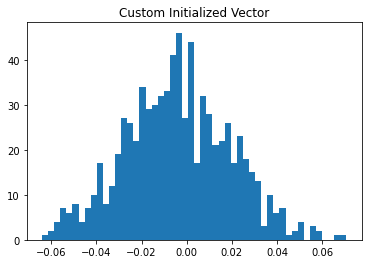

In [ ]:
mean_vector = scibert_maskedlm_model.get_input_embeddings().weight[-1].detach().numpy()

plt.title("Custom Initialized Vector")
plt.hist(mean_vector, bins=50)
plt.show()

As we can see, this is different from the randomly initialized vector we had before, so the update was successful.

Let's make a copy of our untrained SciBERT model to use for comparison later.

In [ ]:
import copy

untrained_scibert_model_with_custom_embedding = copy.deepcopy(scibert_maskedlm_model)
untrained_scibert_tokenizer_with_custom_embedding = copy.deepcopy(scibert_tokenizer)

# S4. Continue Pretraining the Model

Now, with our updated vocabulary let's continue to train SciBERT on COVID-19 literature to improve downstream model performance on COVID-19 related NLP tasks.

## 4.1 Getting our Dataset Ready

The [CORD-19](https://allenai.org/data/cord-19) dataset from Allen AI is large collection of COVID-19 related text and numerical data. This data has been used by the data science community to produce insights and analysis to further progress COVID-19 research and care. If this interests you, check out Kaggle for a ton of great user-submitted analyses and focused research questions that the medical community is trying to answer.

The CORD-19 dataset is, however, very large and requires preprocessing, so for our purposes of demonstrating pretraining we will use a smaller subset of coronavirus research. [This dataset](https://www.kaggle.com/phiitm/covid19-research-preprint-data) made by Pranav Hari contains several thousand rows of data on COVID-19 research papers, including the abstract for each paper. This is the text that we will use for continuing pretraining. 

We've added the dataset to Google Drive beforehand and can now download the dataset using the unique Drive ID:

In [ ]:
import gdown

print('Downloading data...')

# Specify the name to give the file locally. 
output = 'abstracts.csv'
    
# Specify the Google Drive ID of the file.
file_id = '1bv_iRnYyfbOA5OfGqR_shYHFuARkPZRT'
    
# Download the file.
gdown.download('https://drive.google.com/uc?id=' + file_id, output, 
                quiet=False)

print('DONE.')

Downloading...
From: https://drive.google.com/uc?id=1bv_iRnYyfbOA5OfGqR_shYHFuARkPZRT
To: /content/abstracts.csv
11.8MB [00:00, 238MB/s]

DONE.


In [ ]:
import pandas as pd

df = pd.read_csv('abstracts.csv')

Let's take a quick look at the dataset:

In [ ]:
df.head()

,DOI,Date of Upload,Title of preprint,Preprint Link,Abstract,Number of Authors,Authors,Author(s) Institutions,Uploaded Site
0,10.1101/2020.06.19.20135996,2020-06-20,The support needs of Australian primary health...,http://medrxiv.org/cgi/content/short/2020.06.1...,Aim: To identify Australian primary healthcare...,7,"['Elizabeth Halcomb', 'Anna Williams', 'Christ...","{""University of Wollongong"": 6, ""University of...",medrxiv
1,10.1101/2020.06.18.20135103,2020-06-20,Modeling quantitative traits for COVID-19 case...,http://medrxiv.org/cgi/content/short/2020.06.1...,Medical practitioners record the condition sta...,6,"['Nuria Queralt-Rosinach', 'Susan Bello', 'Rob...","{""Leids Universitair Medisch Centrum"": 1, ""The...",medrxiv
2,10.1101/2020.06.19.20135905,2020-06-20,SARS-CoV-2 RT-PCR profile in 298 Indian COVID-...,http://medrxiv.org/cgi/content/short/2020.06.1...,Background: Despite being in the 5th month of ...,9,"['bisakh bhattacharya', 'Rohit Kumar', 'Dr. Ve...","{""AIIMS, New Delhi"": 8, ""All India Institute o...",medrxiv
3,10.1101/2020.06.19.20135491,2020-06-20,Inhaled corticosteroid use and risk COVID-19 r...,http://medrxiv.org/cgi/content/short/2020.06.1...,Background: Early descriptions of the coronavi...,33,"['- The OpenSAFELY Collaborative', 'Anna Schul...","{"""": 1, ""London School of Hygiene and Tropical...",medrxiv
4,10.1101/2020.06.19.20135533,2020-06-20,The immediate psychological response of the ge...,http://medrxiv.org/cgi/content/short/2020.06.1...,Background: The health and economic burden pan...,4,"['Royes Joseph', 'Dhfer Alshayban', 'Jisha M L...","{""College of Clinical Pharmacy, Imam Abdulrahm...",medrxiv


What we're really interested in is text data for pretraining, so we'll use the abstracts from these research papers.

In [ ]:
# Examples of our abstracts
df.Abstract.values[:3]

array(["Aim: To identify Australian primary healthcare nurses immediate support needs during the COVID-19 pandemic. Background: COVID-19 has had widespread implications for primary healthcare nurses. Supporting these nurses' capacity to deliver quality care ensures that ongoing health needs can be met. Methods: Primary healthcare nurses were recruited to an online survey via social media and professional organisations in April 2020. Results: Six-hundred and thirty-seven responses were included in analysis. Participants provided 1213 statements about perceived supports required to provide quality clinical care. From these, seven key categories emerged, namely; personal protective equipment, communication, funding, industrial issues, self-care, workplace factors and valuing nurses. Conclusion: A number of key issues relating to personal health and safety, care quality, and job security need to be addressed to support primary healthcare nurses during the COVID-19 pandemic. Addressing thes

In [ ]:
abstracts = df.Abstract.values

Next, we'll write all of the abstracts line by line to a text file. This provides an easy and memory efficient format for the training loop below, but you can customize the input and data format to match your dataset so long as you update the huggingface Trainer interface below.

In [ ]:
outfile = open("abstracts.txt", "w")
for line in abstracts:
  outfile.write(line.lower())
  outfile.write("\n")
outfile.close()

## 4.2 Training the Model

In [ ]:
# Check that we have a GPU for training
!nvidia-smi

Wed Jun 24 19:49:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    60W / 149W |   8107MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check that PyTorch sees it
torch.cuda.is_available()

True

The code below for training and evaluation is based heavily on the ["how to train" tutorial](https://colab.research.google.com/github/huggingface/blog/blob/master/notebooks/01_how_to_train.ipynb) provided by huggingface, and demonstrates the use of their Trainer class and Pipeline class. The Trainer class is an alternative to writing your own training loop, and provides the same level of specification with much less code! The pipeline class is also a handy way to evaluate and test your model without having to manually code inputs, outputs, similarity comparisons, etc.

(By the way, if you'd like to train a tokenizer and model from scratch the huggingface tutorial is a great resource!)

In [ ]:
from transformers import LineByLineTextDataset

# Create a LineByLineTextDataset interface for reading and tokenizing our text dataset
dataset = LineByLineTextDataset(
    tokenizer=scibert_tokenizer,
    file_path="abstracts.txt",
    block_size=128,
)

The DataCollatorForLanguageModeling creates batches out of our dataset and allows us to specify the MLM probability for training.

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=scibert_tokenizer, mlm=True, mlm_probability=0.15
)

With the TrainingArguments class you can customize nearly every optimizer parameter, logging parameter, training loop parameter, etc. in one place. 

We'll train for just two epochs so we can quickly examine the results and check that the model has updated with continued training.

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(   
    output_dir="./",
    overwrite_output_dir=True,
    learning_rate=5e-05, 
    num_train_epochs=1,
    per_gpu_train_batch_size=32,
    save_steps=500,
    save_total_limit=2,
)

trainer = Trainer(
    model=scibert_maskedlm_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset= dataset
)

In [ ]:
%%time
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.




CPU times: user 2min 59s, sys: 1min 59s, total: 4min 58s
Wall time: 4min 59s


TrainOutput(global_step=190, training_loss=1.4379032254219055)

In [ ]:
# Save the model
trainer.save_model("./covid_trained")

# S5. Examining our Results

OK, let's take a look at the results of our trained model.

In [ ]:
# Load our saved model and check out our embeddings!
from transformers import BertForMaskedLM
trained_model = BertForMaskedLM.from_pretrained("./covid_trained")


## 5.1 Check Embeddings

Here's the original custom embedding we used for "covid":

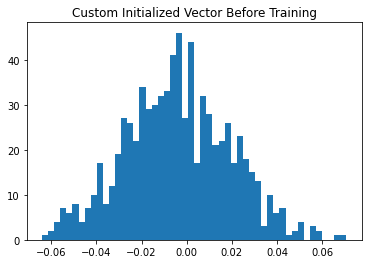

In [ ]:
mean_vector = mean_embedding.detach().numpy()

plt.title("Custom Initialized Vector Before Training")
plt.hist(mean_vector, bins=50)
plt.show()

And here's the same vector after our training:

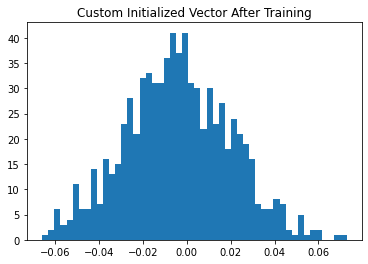

In [ ]:
trained_vector = trained_model.get_input_embeddings().weight[-1].detach().numpy()

plt.title("Custom Initialized Vector After Training")
plt.hist(trained_vector, bins=50)
plt.show()

Great! Training has updated our new input embedding for "covid" and has updated the weights in the rest of our model.

## 5.2 Check Token Predictions

Now let's compare the term "covid" on three versions of our model:



1.   Original SciBERT with original SciBERT tokenizer
2.   SciBERT with a custom embedding for "covid" with updated SciBERT tokenizer
3.   SciBERT with a custom embedding for "covid" that has been trained on COVID-19 text with updated SciBERT tokenizer

Let's load the original SciBERT and SciBERT tokenizer:



In [ ]:
# Load the original SciBERT
original_scibert_model = BertForMaskedLM.from_pretrained("allenai/scibert_scivocab_uncased")
original_scibert_tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", do_lower_case=True)

OK, now we have all three models loaded. 

We'll use the huggingface pipeline class to do a quick comparison of our embeddings. The "fill-mask" option lets us feed in a sentence with one token substituted with a mask token. The sentence gets tokenized, run through the model, and returns the top N most probable tokens to fill that embedding.

In [ ]:
from transformers import pipeline

# Pipeline for Original SciBERT
fill_mask_original_scibert = pipeline( 
    "fill-mask",
    model=original_scibert_model,
    tokenizer=original_scibert_tokenizer
)

# Pipeline for our custom "covid" embedding
fill_mask_untrained_scibert_with_embedding = pipeline( 
    "fill-mask",
    model=untrained_scibert_model_with_custom_embedding,
    tokenizer=untrained_scibert_tokenizer_with_custom_embedding
)

# Pipeline for our trained model
fill_mask_trained_scibert = pipeline( 
    "fill-mask",
    model=trained_model,
    tokenizer=untrained_scibert_tokenizer_with_custom_embedding
)

In [ ]:
# Check to see what the tokenizer's mask token is
original_scibert_tokenizer.mask_token

'[MASK]'

OK! Now we can run the same sentence:

**"covid is a [MASK]"**

through our three models and see what it predicts as most likely on the other end!

As we expected, the **Original SciBERT** doesn't have a good idea of what "covid" is at all, it's simply trying to make sense out of subtokens "cov" + "##id"

In [ ]:
fill_mask_original_scibert("covid is a [MASK].")

[{'score': 0.02992258034646511,
  'sequence': '[CLS] covid is a constant. [SEP]',
  'token': 2080},
 {'score': 0.015606057830154896,
  'sequence': '[CLS] covid is a singleton. [SEP]',
  'token': 23128},
 {'score': 0.015586997382342815,
  'sequence': '[CLS] covid is a set. [SEP]',
  'token': 610},
 {'score': 0.015000350773334503,
  'sequence': '[CLS] covid is a proof. [SEP]',
  'token': 2254},
 {'score': 0.014042431488633156,
  'sequence': '[CLS] covid is a vector. [SEP]',
  'token': 2069}]

**SciBERT with a custom embedding for "covid"** does substantially better. As it turns out, our custom embedding of "virus" + "respiratory" does a pretty good first pass job.

In [ ]:
fill_mask_untrained_scibert_with_embedding("covid is a [MASK].")

[{'score': 0.24134275317192078,
  'sequence': '[CLS] covid is a virus. [SEP]',
  'token': 2930},
 {'score': 0.015654005110263824,
  'sequence': '[CLS] covid is a disease. [SEP]',
  'token': 1288},
 {'score': 0.00870219524949789,
  'sequence': '[CLS] covid is a problem. [SEP]',
  'token': 1167},
 {'score': 0.00780594814568758,
  'sequence': '[CLS] covid is a name. [SEP]',
  'token': 5147},
 {'score': 0.007489326875656843,
  'sequence': '[CLS] covid is a pandemic. [SEP]',
  'token': 26196}]

Even with just one epoch of training on some abstracts, **Trained SciBERT** does an even better job. Notice here that the scores values are higher than they were for our custom embedding and the predicted tokens are more accurate; the uninformative "name" was a top 5 candidate for our custom embedding but for our trained model this is replaced with "pathogen."

In [ ]:
fill_mask_trained_scibert("covid is a [MASK].")

[{'score': 0.7195270657539368,
  'sequence': '[CLS] covid is a pandemic. [SEP]',
  'token': 26196},
 {'score': 0.08424169570207596,
  'sequence': '[CLS] covid is a disease. [SEP]',
  'token': 1288},
 {'score': 0.05053684487938881,
  'sequence': '[CLS] covid is a virus. [SEP]',
  'token': 2930},
 {'score': 0.0171565730124712,
  'sequence': '[CLS] covid is a pathogen. [SEP]',
  'token': 9293},
 {'score': 0.011855337768793106,
  'sequence': '[CLS] covid is a threat. [SEP]',
  'token': 8057}]

This indicates that the model we have trained is better suited as a COVID-19 language model or as the basis for fine-tuning.

Similarly, we hope this tutorial will help you in customizing and improving a BERT-like language model for your specific downstream application. 

# Appendix - Additional Resources


While most of the literature is focused on fine-tuning against benchmarks, there isn't a great deal of research we've come across about continued pretraining or domain-specific fine-tuning despite its utility to industry-specific applications.

One paper which does address this topic is "[BERT on Stilts](https://arxiv.org/pdf/1811.01088.pdf)" from a team at NYU--they measure the positive impact of an intermediate fine-tuning phase prior to the final benchmarked fine-tuning task.

We'll continue to add more resources here as we come across them!



